In [21]:
import sys
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab_Notebooks/DeepSynergy"
import os
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import pandas as pd
import pickle 
import gzip

In [23]:
#contains the data in 
#both feature ordering ways (drug A - drug B - cell line and drug B - drug A - cell line)
#in the first half of the data the features are ordered (drug A - drug B - cell line)
#in the second half of the data the features are ordered (drug B - drug A - cell line)
file = gzip.open('./dataset/X.p.gz', 'rb')
X = pickle.load(file)
file.close()

For 15 overlapping drugs

In [24]:
drugs = pd.read_csv('dataset/ONeil38_Drug732.csv')
drugs_name = drugs['ONeil_name'].str.upper()

# find the index where combinations only involves the 15 overlapping drugs
labels = pd.read_csv('dataset/labels.csv')  # y's for one ordering way
selected = labels[(labels['drug_a_name'].isin(drugs_name)) & (labels['drug_b_name'].isin(drugs_name))]

# regenerate folds 
import random
random.seed(123)
selected.fold = 5

each_num = int(len(selected)/5)
folds = np.array(each_num*[0]+each_num*[1]+each_num*[2]+each_num*[3]+(len(selected)-4*each_num)*[4])
random.shuffle(folds)

selected.loc[:,'fold'] = folds
selected.to_csv('dataset/labels_15.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [25]:
selected.shape

(3003, 6)

## The following part is for embedding


Cell line

In [26]:
cell_line = X[:,-3984:]

每个gene的count除以该细胞的总count,乘以缩放因子10000再进行log1p处理

In [27]:
cell_line_norm = np.log1p(np.divide(cell_line, cell_line.sum(axis=1)[:,None]) * 10000)

We first observe the highly variable features (top 500). (For the entire dataset, not only for the 15 overlapping drugs)

[1657, 3226, 2835, 3603, 2808, 1723, 2864, 3059, 3020, 234, 1365, 1182, 1725, 2982, 1653, 1648, 141, 3130, 1624, 2635, 1259, 1647, 908, 1551, 1687, 1682, 1688, 3197, 965, 309, 2187, 2827, 1587, 688, 3109, 689, 421, 586, 1550, 1506, 1428, 1300, 1664, 1883, 1570, 1589, 2417, 1413, 1980, 3628, 1724, 3106, 831, 630, 2941, 1798, 555, 2826, 3124, 3875, 1731, 1571, 785, 541, 1422, 1582, 1181, 443, 1596, 3112, 735, 2790, 720, 1743, 618, 591, 274, 1925, 1812, 3153, 3658, 1184, 3271, 1569, 658, 3016, 3019, 3044, 1566, 374, 1458, 2834, 3108, 1926, 8, 1081, 1896, 685, 1061, 1533, 3180, 1207, 2970, 41, 2609, 1768, 1685, 1299, 1779, 470, 2907, 1051, 2799, 3255, 3146, 1260, 3122, 232, 3560, 1722, 2779, 2831, 576, 2969, 3570, 1085, 136, 1736, 3906, 3501, 1352, 3724, 1807, 495, 987, 3619, 160, 224, 1455, 1211, 3490, 3185, 3808, 2143, 1258, 597, 3903, 2524, 1395, 846, 3222, 2745, 833, 2481, 2983, 2682, 143, 1127, 1583, 2515, 1002, 99, 3139, 3087, 573, 2825, 2830, 2150, 3181, 841, 738, 2816, 1110, 1201, 

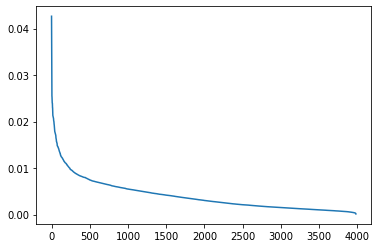

In [28]:
import heapq
features_var = list(cell_line_norm.var(axis=0))
re1 = list(map(features_var.index, heapq.nlargest(500, features_var))) #索引
re2 = heapq.nlargest(500, features_var) #元素
print(re1) 
print(cell_line_norm.var(axis=0)[re1])
import matplotlib.pyplot as plt
re1_sort = np.sort(cell_line_norm.var(axis=0))[::-1]
plt.plot(re1_sort)

In [29]:
# take the top 200 highly vairable features
features_top200 = cell_line_norm[:,list(map(features_var.index, heapq.nlargest(200, features_var)))]

Then we apply pca (elbow plot first).

[ 1.12829746e-11  2.13251639e-11  1.72919457e-11 -1.89670502e-12
 -9.45377110e-12 -1.31219480e-11 -5.76938497e-11 -1.39301903e-11
  2.52935450e-11 -6.90469903e-12  2.49817944e-11 -2.73452372e-11
  3.13353787e-11  4.79936091e-11  7.45252748e-11  6.18438634e-11
  2.86908275e-11 -3.15560911e-11 -7.94946331e-11 -4.80451234e-11
  6.41708908e-11 -5.09920994e-11 -9.03632724e-12 -1.76214598e-12
  5.60884672e-12 -1.88777882e-11 -6.62057076e-11  1.74709136e-11
  5.01216846e-11  1.66915370e-11 -2.61790589e-12 -4.90540941e-11
  1.20792265e-13 -1.70992109e-11  2.80735435e-11  4.46185311e-11
  1.80184756e-11  7.55493446e-11 -7.60902452e-12 -1.09916520e-11
 -4.22879509e-11  4.53534987e-11 -3.46371820e-11  1.43700607e-11
  6.73017198e-13 -1.77067250e-11 -6.50146603e-13 -3.83670873e-11
  9.37916411e-12 -3.61897179e-11  3.94533295e-11 -2.47286636e-11
 -3.01358938e-11 -1.43618450e-12  2.05493400e-11  1.11774590e-10
 -3.04858361e-11 -8.19406765e-11 -1.85651494e-11  2.70379275e-11
  7.65707497e-11  3.48885

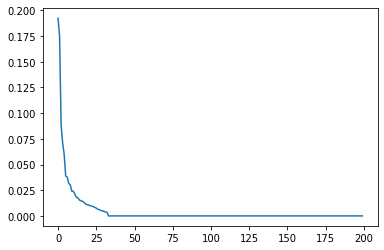

In [30]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
# scaling
scaler = preprocessing.StandardScaler()
features_norm = scaler.fit_transform(features_top200)
print(features_norm.sum(axis=0), features_norm.var(axis=0))
pca = PCA() #(n_components=33, copy=True, whiten=False)
features_pca = pca.fit(features_norm)   #fit_transform
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)

In [31]:
# take top 33 (12) directions 
pca = PCA(n_components=33) #(n_components=12, copy=True, whiten=False)
features_pca = pca.fit_transform(features_norm)

Embedding for the 15 overlapping drugs

In [32]:
drugs_embedding = pd.read_csv('dataset/drugfeatures_overlapped_ONeil38_Drug732.csv', header = None)
drugs_embedding[1] = drugs_name

In [33]:
# generate X for the selected (y)
#contains the data in both feature ordering ways (drug A - drug B - cell line and drug B - drug A - cell line)
#in the first half of the data the features are ordered (drug A - drug B - cell line)
#in the second half of the data the features are ordered (drug B - drug A - cell line)


X_emb = [] 
for i in range(len(selected)):
    drug_a = selected.iloc[i]['drug_a_name']
    drug_a_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_a]).reshape(-1,)[2:])
    drug_b = selected.iloc[i]['drug_b_name']
    drug_b_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_b]).reshape(-1,)[2:])
    cell_line_ind = selected.index[i]
    cell_line_emb = list(features_pca[cell_line_ind])


    X_emb.append(drug_a_emb+drug_b_emb+cell_line_emb)

for i in range(len(selected)):
    drug_a = selected.iloc[i]['drug_a_name']
    drug_a_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_a]).reshape(-1,)[2:])
    drug_b = selected.iloc[i]['drug_b_name']
    drug_b_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_b]).reshape(-1,)[2:])
    cell_line_ind = selected.index[i]
    cell_line_emb = list(features_pca[cell_line_ind])

    X_emb.append(drug_b_emb+drug_a_emb+cell_line_emb)

# scale X_emb to balance among drug_a drug_b and cell line
# scale each embedding to have mean 0 and variance 1
X_emb = np.array(X_emb)
scaler = preprocessing.StandardScaler()

X_emb[:,:10] = scaler.fit_transform(X_emb[:,:10])
X_emb[:,10:20] = scaler.fit_transform(X_emb[:,10:20])
X_emb[:,20:] = scaler.fit_transform(X_emb[:,20:])
#X_emb = scaler.fit_transform(X_emb)

In [34]:
with gzip.open('./dataset/X_15_emb_c33.p', "wb") as f:
    pickle.dump(X_emb, f)

## For original input

In [35]:
X_15drugs_39cel = np.vstack([X[selected.index], X[selected.index+int(X.shape[0]/2)]])

In [36]:
with gzip.open('./dataset/X_15.p', "wb") as f:
    pickle.dump(X_15drugs_39cel, f)